In [1]:
import xarray as xr
import os
import numpy as np
import sys
import json
from datetime import datetime
from S2S_on_SFNO.Models.provenance import system_monitor
from multiprocessing import Pool, active_children
from time import sleep




In [2]:
from time import time
# import matplotlib.pyplot as plt # no modules

In [3]:

from functools import partial
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import torch_geometric.utils as gutils

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


### reshape

In [13]:
corse_deg=4
edge_index = torch.load("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/edge_index_coarsen_"+str(corse_deg)+".pt")
nan_mask = np.load("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/nan_mask_coarsen_"+str(corse_deg)+".npy")
adj_fully = torch.load(os.path.join("/mnt/qb/work2/goswami0/gkd965/Assets/gcn","adj_coarsen_"+str(corse_deg)+"_fully.pt"))

In [11]:
nan_mask_noflatten = nan_mask.reshape((180,360))
print(nan_mask_noflatten.shape)
# np.save("/mnt/V/Master/model/nan_mask_maksed_{}".format(corse_deg),new_nan_mask.flatten())
np.save("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/nan_mask_coarsen_"+str(corse_deg)+"_notflatten.npy",nan_mask_noflatten)

(180, 360)


In [16]:
print(adj_fully.squeeze().shape)
torch.save(adj_fully.squeeze(),os.path.join("/mnt/qb/work2/goswami0/gkd965/Assets/gcn","adj_coarsen_"+str(corse_deg)+"_fully.pt"))

torch.Size([45171, 45171])


## Generate Adj

In [5]:
corse_deg = 4
# edge_index = torch.load("/mnt/V/Master/model/edge_index_coarsen_"+str(corse_deg)+".pt")
# nan_mask = np.load("/mnt/V/Master/model/nan_mask_coarsen_"+str(corse_deg)+".npy")
edge_index = torch.load("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/edge_index_coarsen_"+str(corse_deg)+".pt")
nan_mask = np.load("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/nan_mask_coarsen_"+str(corse_deg)+".npy")
adj = gutils.to_torch_coo_tensor(edge_index= edge_index)
adj_dense = gutils.to_dense_adj(edge_index= edge_index)
degree = gutils.degree(edge_index[0])

In [6]:
print(adj_dense.shape)
print(adj.shape)
print(edge_index.shape)
print(nan_mask.shape)
print('num of non nans',np.sum(nan_mask))
print(degree.shape)

torch.Size([1, 45171, 45171])
torch.Size([45171, 45171])
torch.Size([2, 349510])
(64800,)
num of non nans 45171
torch.Size([45171])


In [7]:
adj_ = adj_dense + torch.diag(torch.ones(adj_dense.shape[1]))

In [8]:
deg_ = torch.diag(1/torch.sqrt(degree + 1))

In [9]:
ADJ = deg_ @ adj_ @ deg_

In [11]:
ADJ.shape

torch.Size([1, 45171, 45171])

In [12]:
torch.save(ADJ,"/mnt/qb/work2/goswami0/gkd965/Assets/gcn/adj_coarsen_4_fully.pt")

In [13]:
ADJ[0,0:10,0:10]

tensor([[0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667,
         0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667,
         0.1667]])

In [14]:
ADJ[0,178:188,178:188]

tensor([[0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667, 0.1667,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.1667,
         0.1667],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667,
         0.1667]])

In [26]:
ADJ

tensor([[[0.1667, 0.1667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1667, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1667, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1667, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000]]])

In [9]:
sp = adj_.squeeze().to_sparse()

In [10]:
sp_deg = deg_.squeeze().to_sparse()

In [11]:
adj_sparse_mm = torch.sparse.mm(sp_deg , torch.sparse.mm( sp , sp_deg ))

/tmp/ipykernel_62358/1759696594.py:1: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_sparse_mm = torch.sparse.mm(sp_deg , torch.sparse.mm( sp , sp_deg ))


In [12]:
torch.save(adj_sparse_mm,"/mnt/qb/work2/goswami0/gkd965/Assets/gcn/adj_coarsen_4_sparse.pt")

In [13]:
test = torch.load("/mnt/qb/work2/goswami0/gkd965/Assets/gcn/adj_coarsen_4_sparse.pt")

In [15]:
test.to_dense()

tensor([[0.1667, 0.1667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1667, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000]])

In [25]:
adj_sparse_mm.to_dense()

tensor([[0.1667, 0.1667, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1667, 0.1667,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1667, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1667, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2000]])

In [ ]:
adj_sparse_mm = torch.sparse.mm(deg_.to_sparse() , torch.sparse.mm( adj_.to_sparse() , deg_.to_sparse() ))

In [ ]:
adj_sparse = deg_.to_sparse() @ adj_.to_sparse() @ deg_.to_sparse()

In [ ]:
torch.spmm(adj, support)

In [10]:
deg_[0:10,0:10]

tensor([[6., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 6., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 6., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 6., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 6., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 6., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 6., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 6., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 6., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 6.]])

In [11]:
t = torch.inverse(deg_[0:10,0:10])
t.shape
t

tensor([[0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1667,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.1667]])

In [12]:
1/6

0.16666666666666666

size of image 180x360

In [32]:
adj_[0,0:10,0:10]

tensor([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.]])

In [24]:
adj_dense[0,0:10,175:185]

tensor([[0., 0., 0., 0., 0., 1., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [25]:
adj_dense[0,0:10,355:365]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [26]:
adj_dense[0,0:10,535:545]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [19]:
degree[0:10]

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5.])

In [30]:
degree.max()

tensor(8.)

In [23]:
adj_dense[0,0,:].nonzero()

tensor([[  1],
        [180],
        [181],
        [359],
        [539]])

In [27]:
adj_dense[0,1,:].nonzero()

tensor([[  0],
        [  2],
        [180],
        [181],
        [182]])

In [28]:
adj_dense[0,2,:].nonzero()

tensor([[  1],
        [  3],
        [181],
        [182],
        [183]])

In [18]:
adj[0:10,0:10]

NotImplementedError: Could not run 'aten::as_strided' with arguments from the 'SparseCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::as_strided' is only available for these backends: [CPU, CUDA, Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterCPU.cpp:31357 [kernel]
CUDA: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterCUDA.cpp:44411 [kernel]
Meta: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterMeta.cpp:26984 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:944 [kernel]
QuantizedCUDA: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterQuantizedCUDA.cpp:459 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterFunctionalization_0.cpp:21977 [kernel]
Named: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/ConjugateFallback.cpp:21 [kernel]
Negative: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/native/NegateFallback.cpp:23 [kernel]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/build/aten/src/ATen/RegisterZeroTensor.cpp:161 [kernel]
ADInplaceOrView: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4832 [kernel]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradHIP: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradMPS: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradIPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradVE: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradMTIA: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradMeta: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/VariableType_0.cpp:17339 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/torch/csrc/autograd/generated/TraceType_0.cpp:16968 [kernel]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:724 [kernel]
BatchedNestedTensor: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1079 [kernel]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /opt/conda/conda-bld/pytorch_1708025842427/work/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


## Models

typical shapes:
sst: (nodes,1)
edges: (2,num edges)

In [5]:
class GCN(torch.nn.Module):
    def __init__(self,out_features=256,num_layers=12):
        super().__init__()
        self.num_layers = num_layers
        num_node_features = 686364
        hidden_size = out_features*2
        self.conv1 = GCNConv(1, hidden_size,cached=True)
        self.conv2 = GCNConv(hidden_size, hidden_size,cached=True)
        self.fc1 = torch.nn.Linear(hidden_size, out_features)
        self.heads_gamma = nn.ModuleList([])
        self.heads_beta = nn.ModuleList([])
        for i in range(self.num_layers):
            self.heads_gamma.append(nn.Linear(hidden_size, out_features))
            self.heads_beta.append(nn.Linear(hidden_size, out_features))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # batch = torch.tensor([0]*x.size().numel(),dtype=torch.long)

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, batch)
        heads_gamma = []
        heads_beta = []
        for i in range(self.num_layers):
            heads_gamma.append(self.heads_gamma[i](x))
            heads_beta.append(self.heads_beta[i](x))
        return torch.stack([torch.stack(heads_gamma),torch.stack(heads_beta)]).squeeze()


In [6]:
class GCN2(torch.nn.Module):
    def __init__(self,out_features=256,num_layers=12):
        super().__init__()
        self.num_layers = num_layers
        num_node_features = 686364
        hidden_size = out_features*2
        self.conv1 = GCNConv(1, hidden_size,cached=True)
        self.conv2 = GCNConv(hidden_size, hidden_size,cached=True)
        self.fc1 = torch.nn.Linear(hidden_size, out_features)
        self.heads_gamma = nn.ModuleList([])
        self.heads_beta = nn.ModuleList([])
        for i in range(self.num_layers):
            self.heads_gamma.append(nn.Linear(hidden_size, out_features))
            self.heads_beta.append(nn.Linear(hidden_size, out_features))

    def forward(self, data):
        x, self.edge_index_batch, self.batch = data.x, data.edge_index, data.batch

        x1 = self.conv1(x, self.edge_index_batch)
        x = x + F.leaky_relu(x1)
        # x = F.dropout(x, training=self.training)
        x2 = self.conv2(x, self.edge_index_batch)
        x = x + F.leaky_relu(x2)
        x3 = self.conv2(x, self.edge_index_batch)
        x = x + F.leaky_relu(x3)
        x = x + self.conv2(x, self.edge_index_batch)
        x = global_mean_pool(x, self.batch)
        heads_gamma = []
        heads_beta = []
        for i in range(self.num_layers):
            heads_gamma.append(self.heads_gamma[i](x))
            heads_beta.append(self.heads_beta[i](x))
        return torch.stack([torch.stack(heads_gamma),torch.stack(heads_beta)]).squeeze() # shape: (2,num_layers,batch_size,embed_dim)



### Example SST

In [20]:
path = "/mnt/V/Master/data/"
# path = "/mnt/qb/goswami/data/era5/single_pressure_level/"
ds = xr.open_dataset(path + "sea_surface_temperature/sea_surface_temperature_2019.nc")
sst = ds.sel(time="2019-01-01T00:00").to_array()[0].to_numpy()


In [4]:
corse_deg = 4
batch_size = 1

## Prepare Model from Loaded masks

In [5]:
edge_index = torch.load("/mnt/V/Master/model/edge_index_coarsen_"+str(corse_deg)+".pt")
nan_mask = np.load("/mnt/V/Master/model/nan_mask_coarsen_"+str(corse_deg)+".npy")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/V/Master/model/edge_index_coarsen_4.pt'

In [ ]:
num_nodes = np.sum(nan_mask)
print(num_nodes)
num_edges = edge_index.shape[1]
print(num_edges)

In [13]:
#  Reduce Coarsen
sst_5 = ds.sel(time=slice("2019-01-01T00:00","2019-01-01T04:00")).coarsen(latitude=corse_deg,longitude=corse_deg,boundary='trim').mean().to_array()[0].to_numpy()


# repeat mask along batch
batch_nan_mask = np.repeat(nan_mask[ np.newaxis,: ], batch_size, axis=0)
# flatten lat long
sst_5_rs = sst_5.reshape(batch_size,-1)


# along same dim
sst_5_nn = sst_5_rs[batch_nan_mask]
print(sst_5_nn.shape)

batch = torch.tensor(list(range(batch_size))*num_nodes).reshape((num_nodes,batch_size)).T.flatten()
offset_ = torch.tensor(list(range(batch_size))*num_edges).reshape((num_edges,batch_size)).T.flatten()*num_nodes
# offset = torch.stack([torch.tensor(offset_),torch.tensor(offset_)])
offset = torch.stack([offset_,offset_])

edge_index_batch = edge_index.repeat((1,batch_size))+offset

data_batch = Data(x=torch.tensor(sst_5_nn)[None].T, edge_index=edge_index_batch,batch=batch)


# data = Data(x=torch.tensor(sst_nn)[None], edge_index=edge_index,batch=[0]*sst_nn.size)

45171

In [ ]:
g = GCN()
g.to(device)
start = time()
out = g(data_batch.to(device))
end = time()
print(end-start)

349510

In [14]:
# explicit batch dim

# sst_5_nn = sst_5_rs[batch_nan_mask]
# print(sst_5_nn.shape)
# set_5_nnn = sst_5_nn.reshape((batch_size,num_nodes))

# batch = np.array(list(range(batch_size))*num_nodes).reshape((num_nodes,batch_size)).T
# data = Data(x=torch.tensor(set_5_nnn), edge_index=edge_index,batch=batch.flatten())

## To create new Maks

In [31]:
def kernel(i,j,w,h,lat,long):
    x_temp = i+w
    y_temp = j+h

    if w == 0:
        x = x_temp
    elif x_temp < 0:
        x = lat + x_temp
    elif x_temp >= lat:
        x = x_temp - lat
    else:
        x = x_temp
    

    if h == 0:
        y = y_temp
    elif y_temp < 0:
        y = long + y_temp
    elif y_temp >= long:
        y = y_temp - long
    else:
        y = y_temp
    return (x,y)

following file:///home/lenny/Downloads/MGCN_SST_R2_v01.pdf

In [67]:
def new_edge_index_func(sst):
    point = []
    neigh = []
    #shape: (num_nodes,features)
    lat,long = sst.shape
    idx = 0
    skip_point = False
    for i in range(lat):
        for j in range(long):
            for w in [-1,0,1]:
                for h in [-1,0,1]:
                    if np.isnan(sst[i,j]):
                        skip_point = True
                        continue
                    if w==0 and h==0:
                        continue
                    neighbour = kernel(i,j,w,h,lat,long)
                    if np.isnan(sst[neighbour]):
                        continue
                    point.append(idx)
                    neigh.append(neighbour[0]*lat+neighbour[1])
            if not skip_point:
                idx += 1
            else:
                skip_point = False
    print(idx)
    edge_index = torch.tensor([point,neigh],dtype=torch.long)
    return edge_index

def new_nan_mask_func(sst):
    return ~np.isnan(sst)


In [62]:
# sst_f = sst.flatten()
# sst_nn = sst_f[~np.isnan(sst_f)][None].T

## Reduce SST

In [68]:
corse_deg = 2

In [69]:
# Coarsen
sst_coarsed_batch = ds.sel(time=slice("2019-01-01T00:00","2019-01-01T04:00")).coarsen(latitude=corse_deg,longitude=corse_deg,boundary='trim').mean().to_array()[0].to_numpy()
sst_coarsed = ds.sel(time="2019-01-01T04:00").coarsen(latitude=corse_deg,longitude=corse_deg,boundary='trim').mean().to_array()[0].to_numpy()


In [70]:
# Mask
sst = xr.open_dataset(path + "sea_surface_temperature/sea_surface_temperature_2019.nc").sel(time="2019-01-01T00:00").to_array()[0].to_numpy()
sst_reduced = sst[:-1:corse_deg,::corse_deg]

In [71]:
print("sst reduced: ",sst_reduced.shape)
print("sst: ",sst.shape)

sst reduced:  (360, 720)
sst:  (721, 1440)


In [72]:
new_nan_mask = new_nan_mask_func(sst_reduced)
new_edge_index = new_edge_index_func(sst_reduced)

171790


In [75]:
print('nans after mask: ',np.isnan(sst_coarsed[new_nan_mask]).sum())
print('nans after mask: ',np.isnan(sst_reduced.flatten()[new_nan_mask.flatten()]).sum())
# print('nans after mask: ',np.isnan(sst_reduced[nan_mask.reshape(180,360)]).sum())
# print('nans after mask: ',np.isnan(sst_coarsed[nan_mask.reshape(180,360)]).sum())
print('num of non nans',np.sum(nan_mask))
print('num of new non nans',np.sum(new_nan_mask))

print('num new edges',new_edge_index.shape[1])
print('num edges',edge_index.shape[1])

nans after mask:  0
nans after mask:  0
num of non nans 45171
num of new non nans 171790
num new edges 1343516
num edges 349510


In [52]:
edge_index.shape

torch.Size([2, 349510])

In [46]:
sst_reduced[new_nan_mask].shape
sst_coarsed.shape

(180, 360)

In [76]:

torch.save(new_edge_index,"/mnt/V/Master/model/edge_index_masked_{}.pt".format(corse_deg))
np.save("/mnt/V/Master/model/nan_mask_maksed_{}".format(corse_deg),new_nan_mask.flatten())

In [84]:
ds.sel(time="2019-01-02T04:00").coarsen(latitude=corse_deg,longitude=corse_deg,boundary='trim').mean().to_array()[0].to_numpy()


array([[271.46014, 271.46014, 271.46014, ..., 271.46014, 271.46014,
        271.46014],
       [271.46014, 271.46014, 271.46014, ..., 271.46014, 271.46014,
        271.46014],
       [271.46014, 271.46014, 271.46014, ..., 271.46014, 271.46014,
        271.46014],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan]], dtype=float32)

In [85]:
ds.sel(time="2019-01-03T04:00").groupby_bins('latitude',180).last().groupby_bins('longitude',360).last().to_array().to_numpy().shape#,longitude=corse_deg,boundary='trim').last()

(1, 360, 180)

In [9]:
import matplotlib.pyplot as plt

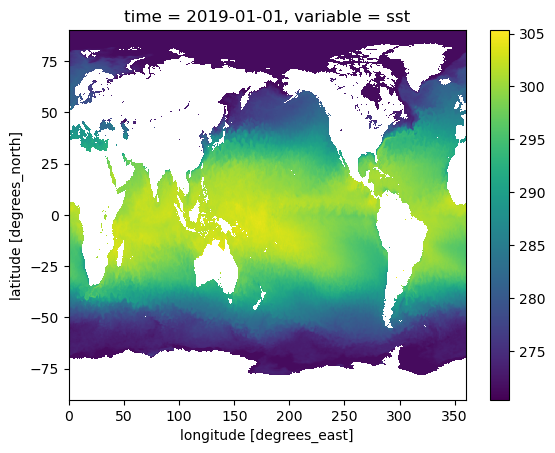

In [7]:

sl.to_array().plot()

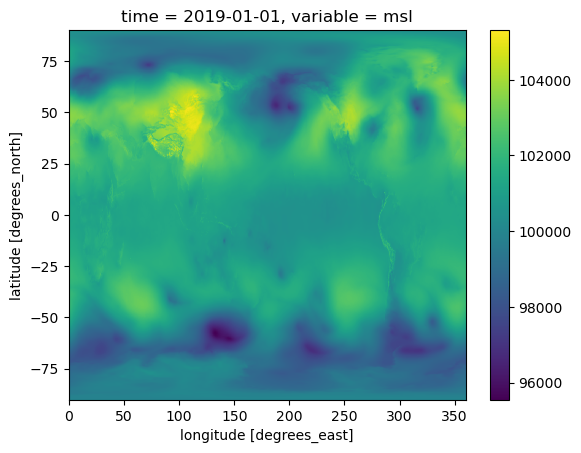

In [13]:

sl_msp.plot()

In [5]:
sst_np = sl.to_numpy()

In [15]:
sst_t = np.invert(np.isnan(sst_np)[0])

In [53]:
plt.imshow(sst_reduced)

NameError: name 'plt' is not defined

In [19]:
num_sst_points = np.sum(sst_t)
print("number of sst points: ",num_sst_points)

number of sst points:  686364


In [20]:
total_points = sst_t.shape[0]*sst_t.shape[1]

In [26]:
percent_water = num_sst_points/total_points
print("number of Water Points: ",round(percent_water,2)*100,"%")

number of Water Points:  66.0 %


In [46]:
embed_dim = 256
scaling = 100

In [47]:
for i in range(1,8):
    print(num_sst_points//(scaling*i))

6863
3431
2287
1715
1372
1143
980


In [31]:
num_sst_points//16

42897

In [32]:
num_sst_points//(16*4)

10724